# Customer Support meets Spacy Universe

This analysis delves into a large dataset of about 3 million tweets focusing around Customer Support queries and responses. Let's see what we can find and explore what the wonderful Spacy library and its ecosystem has to offer, documenting the trial and errors, ideas and possible further analysis along the way.

**Contents : **

*  [Data Wrangling](#data-wrangling)
*  [Visualisation](#visual)
*  [Houston! We have a problem!](#problem)
*  [Emojis with spacymoji](#emojis)
*  [Sentimental Emojis!](#senti)
*  [Scattertext - a hidden gem in the Spacy Universe](#scatter)
*  [Word Embedding projection plots using Scattertext](#embedding)

In [ ]:
#!conda install -c conda-forge -y textblob scattertext

In [ ]:
#!pip install spacy_cld

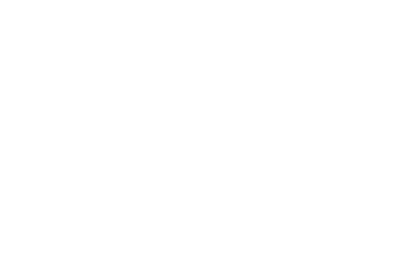

In [3]:
# library imports
import re
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
width = 0.75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.axis('off')
#from nltk.corpus import stopwords
#from textblob import TextBlob
#import scattertext as st
#import spacy
#import spacy_cld

from IPython.display import IFrame
from IPython.core.display import display, HTML
from collections import Counter
#from tqdm import tqdm_notebook as tqdm  # cool progress bars
#tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls

First lets get our data and process it to our needs

In [5]:
tweets = pd.read_csv('../twcs.csv',encoding='utf-8')
print(tweets.shape)
tweets.head()

(2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


<a id='data-wrangling'></a>

## Data Wrangling

This is a very interesting tweet data set, about 3 million tweets, and we have information on the author of the tweets and whether the tweet was a query or a response (the "inbound" column). If the tweet was a query, the response_tweet_id gives the response made by the support team.

It would be interesting to modify this dataframe to get query - response pairs in every row.
The following code, to do just what we want, was pulled from [this kernel](https://www.kaggle.com/soaxelbrooke/first-inbound-and-response-tweets)

In [6]:
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

QnR = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter to only outbound replies (from companies)
QnR = QnR[QnR.inbound_y ^ True]
print(f'Data shape: {QnR.shape}')
QnR.head()

Data shape: (794299, 14)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0


In [ ]:
# removing anonymized screen names 
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return ''

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Removing anonymized screen names in X...")
QnR["text_x"] = QnR.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Removing anonymized screen names in Y...")
QnR["text_y"] = QnR.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

In [7]:
#making sure the dataframe contains only the needed columns
QnR = QnR[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]
QnR.head(5)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
0,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...
1,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...
2,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...
3,115713,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,sprintcare,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...
4,115715,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",sprintcare,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...


In [8]:
tweet_data = QnR

In [83]:
tweet_data['text'] = tweet_data['text_x'] + ' | ' + tweet_data['text_y']

In [85]:
tweet_data['text'].sample(1000).to_csv('./tweet_random.csv', encoding='utf-8', index=False)
#tweet_telco_negative_final['Raw_Text'].to_csv('./raw_negative.csv', encoding='utf-8', index=False)

In [9]:
tweet_telco = tweet_data[tweet_data["author_id_y"].isin(["TMobileHelp", "sprintcare"])]

In [12]:
tweet_telco['text'] = tweet_telco['text_x'] + ' | ' + tweet_telco['text_y']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
import csv
tweet_telco_text= tweet_telco[["text"]]
tweet_telco_text['text'].to_csv('./tweet_telco.csv', encoding='utf-8', index=False, header=False, doublequote=False)
tweet_telco_text.head()

TypeError: to_csv() got an unexpected keyword argument 'doublequote'

In [14]:
tweet_telco_text.head()

,text
0,@sprintcare is the worst customer service | @1...
1,@sprintcare is the worst customer service | @1...
2,@sprintcare is the worst customer service | @1...
3,@115714 y’all lie about your “great” connectio...
4,"@115714 whenever I contact customer support, t..."


In [15]:
tweet_telco_text_negative = tweet_telco_text

In [ ]:
To print out without the quotes.
>> df.to_csv("out.tsv", , sep="\t", quoting=csv.QUOTE_NONE, quotechar="",  escapechar="\\")

In [ ]:
!head tweet_telco.csv

In [74]:

tweet_telco_text_negative['match']=tweet_telco_text['text'].str.extract(r'(Really|cheated|annoyed|unhelpful|frustrated|upset|unhappy|angry|badly|bad|surprised|sadly|dissatisfied|disappointed|disgusted)', expand=True)



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [75]:
tweet_telco_text_negative.head(100)

,text,match
0,@sprintcare is the worst customer service | @1...,NaN
1,@sprintcare is the worst customer service | @1...,NaN
2,@sprintcare is the worst customer service | @1...,NaN
3,@115714 y’all lie about your “great” connectio...,NaN
4,"@115714 whenever I contact customer support, t...",NaN
251,@115913 @115911 just called in to switch from ...,NaN
252,@TMobileHelp trying to redeem a free tuesday c...,NaN
253,T-Mobile So Bs My Internet Stop Working For 3 ...,NaN
254,No. That opportunity has passed. Bad customer ...,NaN
255,@TMobileHelp @1247 The @10568 code is not work...,NaN


In [76]:
tweet_telco_negative_final = tweet_telco_text_negative[tweet_telco_text_negative['match'].notnull()]

In [77]:
tweet_telco_negative_final['Type'] = 'NEGATIVE'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [78]:
tweet_telco_negative_final = tweet_telco_negative_final.rename(index=str, columns={"text": "Raw_Text", "match": "Text"})

In [79]:
tweet_telco_negative_final.count()

Raw_Text    1484
Text        1484
Type        1484
dtype: int64

In [80]:
tweet_telco_negative_final['Raw_Text'].to_csv('./raw_negative.csv', encoding='utf-8', index=False)


In [81]:
tweet_telco_negative_final[['Text', 'Type']].to_csv('./entity_list_negative.csv', encoding='utf-8', index=False)


In [ ]:
tweet_telco_final['Raw_Text'].tail(10000).to_csv('./telco_device_test.csv', encoding='utf-8', index=False)

In [ ]:
aws comprehend start-entities-detection-job \
     --entity-recognizer-arn "arn:aws:comprehend:us-east-1:202860692096:entity-recognizer/Negativity-copy" \
     --job-name Test \
     --data-access-role-arn "arn:aws:iam::202860692096:role/service-role/AmazonComprehendServiceRole-AmazonComprehendServiceRole" \
     --language-code en \
     --input-data-config "S3Uri=s3://data-phi/telco_random.csv" \
     --output-data-config "S3Uri=s3://data-phi/telco_negative" \
     --region "us-east-1"

In [ ]:
tweet_telco_text.describe()

In [ ]:
tweet_telco[tweet_telco['text_x'].str.contains('android|Android|iphone|iPhone')].count()

In [ ]:
tweet_data.head(5)

<a id='visual'></a>

Now let's get the number of tweets in the dataset for each company and plot the data where number of tweets > 15000

In [ ]:
count = QnR.groupby("author_id_y")["text_x"].count()
c = count[count>15000].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2, width=width,)
c.set_ylabel('')
plt.show()

Looks like the dataset has a lot of tweets for AmazonHelp. Lets take a closer look at queries to @AmazonHelp and their responses

In [ ]:
amazonQnR = QnR[QnR["author_id_y"]=="AmazonHelp"]

The last 10 queries to @AmazonHelp

<a id='problem'></a>

In [ ]:
amazonQnR.tail(10)["text_x"]

## Houston, we have a problem!

Too many different languages! It was assumed that the dataset contained only English tweets, but as seen above, that is definitely not the case.

Fortunately, the solution exists within the [spacy universe](https://spacy.io/universe/) itself! (PUN totally intended)

Since version 2, spacy has support for custom "extensions" and the **[spacy-cld](https://github.com/nickdavidhaynes/spacy-cld) ** extension which wraps the Python wrapper of Google's `Compact Language Detector 2` is just what we require.

Pluggable interfaces are so awesome!

In [ ]:
# amazonQnR["text_x"] = amazonQnR["text_x"].str.encode("utf-8")
# amazonQnR["text_x"] = amazonQnR["text_x"].apply(str)

In [ ]:
nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
language_detector = spacy_cld.LanguageDetector()
nlp_cld.add_pipe(language_detector)

The above code loads up a spacy pipeline disabling the tagger and ner, since we don't require it right now. Then the `spacy_cld` `LanguageDetector` pipe is added for detecting languages in the text data we have.


The following code is an example of how `spacy_cld` adds `languages` and `language_scores`

In [ ]:
doc = nlp_cld(amazonQnR.iloc[4]["text_x"])
print(doc)
print(doc._.languages)  
print(doc._.language_scores)

Let's make a mask which will allow us to select the values

In [ ]:
mask = []
try:
    for i,doc in tqdm(enumerate(nlp_cld.pipe(amazonQnR["text_x"], batch_size=512))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
except Exception:
    print("excepted ")

In [ ]:
amazonQnR = amazonQnR[mask]
# sample a random fraction to visually ensure that we have only English tweets
amazonQnR.sample(frac=0.0002)    

Problem solved, we have removed all the text which is in a language other than English

Now back to the analysis, where were we? 
Peeking into queries to @AmazonHelp

In [ ]:
amazonQnR.tail(10)["text_x"]

<a id='emojis'></a>

## Emojis with spacymoji

Interestingly, during the process of cleaning our data, I saw that some queries and replies had emoji's in them. Wouldn't it be nice to know which smiley is most used by Customers in their queries and the Companies in their responses?

Shout out to Spacy Universe again, with its cool extension named [spacymoji](https://github.com/ines/spacymoji/)

In [ ]:
nlp = spacy.load("en_core_web_lg",disable_pipes=["tagger"])

from spacymoji import Emoji
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)

While we're at it, Spacy has pretrained models for entity extraction, let's use that as well and see which product gets most queries.
The pipes in spacy can be seen using the following code :

In [ ]:
print(nlp.pipe_names)

In [ ]:
emojis = []
for doc in tqdm(nlp.pipe(amazonQnR["text_x"], batch_size=512)):
    if doc._.has_emoji:
        for e in doc._.emoji:
            emojis.extend(e[0])

 **Emoji Count**

**Top Emojis in query tweets by Customers**

In [ ]:
eCount = Counter(emojis)
eCount.most_common(10)

As expected, the red angry face 😡, the confused 🤔and the annoyed 🙄emojis are two of the most commonly used one by customers who are clearly venting their anger, confusion and annoyance at something that went wrong and requires support.

Its a little surprising to find the laughter 😂emoji being this common, but that probably indicates that twitter users are quite sarcastic?

In [ ]:
response_emojis = []
for doc in tqdm(nlp.pipe(amazonQnR["text_y"], batch_size=512)):
    elist = []
    if doc._.has_emoji:
        for e in doc._.emoji:
            elist.append(e[0])
    response_emojis.append(elist)

**Top Emojis in response tweets by Customer Support teams**

In [ ]:
Counter([item for sublist in response_emojis for item in sublist]).most_common(10)

My hypothesis for this result is that responses from customer support teams often do not put emojis when responding to Angry queries. They tend to respond to positive customer tweets with the smiling 😊and cheerful 😁emojis. Need to validate this hypothesis using sentiment analysis and checking for common emojis in response to positve and negative queries

Let's give it a shot!

<a id='senti'></a>

## Sentimental Emojis

This is where we hit a wall in the Spacy Universe, spacy does not have a pretrained model for sentiment analysis, the reason being non availability of a good public dataset as mentioned by spacy creator Honnibal [ here](https://github.com/explosion/spaCy/issues/765#issuecomment-372058333)

Here's another idea for a spacy extension - a quick, rudimentary sentiment analysis extension. If you feel inspired, go ahead and make one, while I put it on my list as well.

Since we just want a quick analysis just to see whether the hypothesis is valid and are not very concerned with accuracy, lets use [vaderSentiment](https://textblob.readthedocs.io/en/dev/)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent_analyser = SentimentIntensityAnalyzer()
positive_text = "love this phone! its the best one I've owned over the years"
negative_text = "what sort of company makes such products? this phone hangs up all the time and is totally useless"
print("positive_text sentiment : ",sent_analyser.polarity_scores(positive_text)["compound"])
print("negative_text sentiment : ",sent_analyser.polarity_scores(negative_text)["compound"])

In [ ]:
def sentiment(text):
    return (sent_analyser.polarity_scores(text)["compound"] + TextBlob(text).sentiment.polarity)/2
amazonQnR["text_x_sentiment"] = amazonQnR["text_x"].apply(sentiment)

In [ ]:
response_emojis_for_positive_queries = []
response_emojis_for_negative_queries = []
for i,sentiment in enumerate(amazonQnR["text_x_sentiment"]):
    if sentiment > 0.0:
        response_emojis_for_positive_queries.extend(response_emojis[i])
    elif sentiment < 0.0:
        response_emojis_for_negative_queries.extend(response_emojis[i])

In [ ]:
amazonQnR[amazonQnR["text_x_sentiment"]>0].head()

**Emojis in responses for positive queries**

In [ ]:
Counter(response_emojis_for_positive_queries).most_common(10)

 **Emojis in responses for negative queries**

In [ ]:
Counter(response_emojis_for_negative_queries).most_common(10)

Looks like our hypothesis is not quite true, emoji's like 😊and 😁are used by support teams for both positive and negative customer queries. However, there is a skew in the number of tweets for each, so we need a more representative dataset and a better sentiment model to study this in depth. We'll defer that for a different session.

**One more look at the number of tweets per company**

In [ ]:
count = QnR.groupby("author_id_y")["text_x"].count()
c = count[count>15000].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2, width=width,)
c.set_ylabel('')
plt.show()

There's a good number of tweets for AmericanAir, British_Airways, Delta and SouthwestAir. Since all these companies provide the same service i.e. flights, it would be interesting to do a comparison

Let's first take a look specifically at American Air and British Airways

In [ ]:
airlinesQnR = QnR[(QnR["author_id_y"]=="AmericanAir")|(QnR["author_id_y"]=="British_Airways")]
airlinesQnR.head(4)

In [ ]:
airlinesQnR["text_y"] = airlinesQnR["text_y"].str.lower()  
stop = stopwords.words('english')
big_regex = re.compile(' | '.join(stop))
airlinesQnR["text_y"].progress_apply(lambda x: big_regex.sub(" ",x))

<a id='scatter'></a>

## Scattertext - a hidden gem in the Spacy Universe

[Scattertext](https://spacy.io/universe/?id=scattertext) is an excellent exploratory text analysis tool, which I would never have stumbled on if not for spacy!
It allows cool visualisations differentiating between the terms used by different documents using an interactive scatter plot.

Let's build one to compare tweet responses by American Airlines vs British Airways :

In [ ]:
import scattertext as st
nlp = spacy.load('en',disable_pipes=["tagger","ner"])
airlinesQnR['parsed'] = airlinesQnR.text_y.progress_apply(nlp)

In [ ]:
corpus = st.CorpusFromParsedDocuments(airlinesQnR,
                             category_col='author_id_y',
                             parsed_col='parsed').build()

In [ ]:
html = st.produce_scattertext_explorer(corpus,
          category='British_Airways',
          category_name='British Airways',
          not_category_name='American Airlines',
          width_in_pixels=600,
          minimum_term_frequency=10,
          term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
          )

Since the D3 visualisation done by scattertext is real awesome, it takes up quite some time to load while viewing as a kaggle kernel and probably take more than 5 minutes to load properly. Check out version 3 or 4 of this kernel if you want to experiment ;) 
Sharing the screenshot image of the plot below.

Make sure you try this kernel out, uncomment the following cell and run it to interact with the plot. It is really worth it!

In [ ]:
# uncomment this cell to load the interactive scattertext visualisation
# filename = "americanAir-vs-britishAirways.html"
# open(filename, 'wb').write(html.encode('utf-8'))
# IFrame(src=filename, width = 800, height=700)

![Imgur](https://i.imgur.com/uBmPKwE.png)

This visualisation can be overwhelming in the beginning, but on a closer look, one can find typical American Airlines references like `aateam`, `aadventures`, `faabulous` and `aadvantage` on the bottom right corner. American Airlines love to use the `double 'a'` reference quite a lot!
British Airways responses,  on the opposite corner in blue color, seem to be very concerned about the `booking reference`

Looks like American Airlines are fond of `kudos`! Try clicking on `kudos` in the chart to see some sample tweets which you can scroll through in the interactive plot. (Try it out by forking the kernel and running the commented out cell above)

## Visualising Empath topics and categories

[Empath](http://empath.stanford.edu/) is a lexical analysis research project at Stanford for Understanding Topic Signals in Large-Scale Text. Read more about it from this [research paper.](https://hci.stanford.edu/publications/2016/ethan/empath-chi-2016.pdf) 

Scattertext has an option for visualising Empath topics and categories, lets use that for our American Airlines vs British Airways analysis

In [ ]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(airlinesQnR,
                                              category_col='author_id_y',
                                              feats_from_spacy_doc=feat_builder,
                                              parsed_col='parsed').build()

In [ ]:
html = st.produce_scattertext_explorer(empath_corpus,
                                        category='British_Airways',
                                        category_name='British Airways',
                                        not_category_name='American Airlines',
                                        width_in_pixels=700,
                                        metadata=airlinesQnR['author_id_y'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=feat_builder.get_top_model_term_lists())

In [ ]:
# uncomment this cell to load the interactive scattertext visualisation
# filename = "empath-BA-vs-AA.html"
# open(filename, 'wb').write(html.encode('utf-8'))
# IFrame(src=filename, width = 900, height=700)

![Imgur](https://i.imgur.com/Gxa086C.png)

On the top right corner, clearly `air_travel` is the most frequent topic for both British Airways and American Airlines since of-course they are flight providers. Topics `urban`, `technology` and `fun` are frequent for British Airways and topics `magic`, `cheerfulness` and `affection` are frequent for American Airlines.

Try clicking on different topics to see which tweets contribute towards the different topics. (Try it out by forking the kernel and running the commented out cell above)

<a id="embedding"></a>

## Word Embedding projection plots using Scattertext

Scatter text can also be used to visualize word embedding projections. We'll explore two such plots 

** 1. Word Association with a specific term**

The first shows word associations to a specific term using Spacy's pretrained embedding vectors. Let's use this to see the terms most associated with the term `delay` since a lot of customer tweets to flight providers will be due to flight delays.

In [ ]:
corpus = (st.CorpusFromParsedDocuments(airlinesQnR,
                             category_col='author_id_y',
                             parsed_col='parsed').build().get_stoplisted_unigram_corpus())

In [ ]:
target_term = 'delay'
html = st.word_similarity_explorer(corpus,
                                   category='British_Airways',
                                   category_name='British Airways',
                                   not_category_name='American Airlines',
                                   target_term=target_term,
                                   minimum_term_frequency=5,
                                   width_in_pixels=800)

In [ ]:
# file_name = 'similarity.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 1000, height=700)

![Imgur](https://i.imgur.com/MX7y2Dy.png)

At the top right corner we see the most commonly associated words with the term `delay` are `late` , `team`, `info` and `patience`. If you click on the interactive version, the list of tweets with the terms can be explored.

**2.  T-SNE style word embedding projection**

In [ ]:
html = st.produce_projection_explorer(corpus,
                                   category='British_Airways',
                                   category_name='British Airways',
                                   not_category_name='American Airlines',
                                   width_in_pixels=800)

In [ ]:
# file_name = 'projection.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 1200, height=700)

![Imgur](https://i.imgur.com/x4AM7mg.png)

* Very interesting to see all the different names of people clustered on the top right corner. 
* At the bottom, slightly towards right side, we see a cluster for places - heathrow, glassgow
* Now, bottom, slightly towards left, we can see terms related to time clustered together - later, close, min, current, hours, prior, daily
* In the top slightly towards left , we see a cluster that is related to passenger information - address, surname etc

Be sure to try the interactive version by running the kernel and mouse over the points to find other clusters, that's where all the fun of Scattertext is!

Scattertext has many more interesting visualisations like this, do check out its [documentation](https://github.com/JasonKessler/scattertext).

A lot more can be done using this dataset and I hope you've got some good ideas to extend this work. This kernel depends on a lot of custom packages, so if you fork and build on top of this kernel, make sure to install the following custom pip packages from the Kaggle Kernel settings interface : vaderSentiment, spacymoji, spacy-cld, scattertext and empath.

Hope this inspired you to try out the different Spacy Extensions available to your own text data.

Thank you :)